In [1]:
import io
import pandas as pd


table = """
deployment,recovery,lat,lon
23/04/2009,10/12/2009,28°29.20'S,047°31.50'W
17/02/2011,03/10/2012,28°29.867'S,047°21.63'W
01/02/2013,26/09/2013,28°29.077'S,047°21.599'W
06/11/2014,29/10/2015,28°31.14'S,047°23.42'W
10/04/2016,03/02/2017,28°30.926'S,047°23.470'W
04/02/2017,03/09/2019,27°24.36'S,047°15.93'W
"""

table = pd.read_csv(io.StringIO(table), parse_dates=["deployment", "recovery"], dayfirst=True)

In [2]:
fname = "itajai/historico_itajai_0.txt"
df = pd.read_csv(fname, index_col="# Datetime", parse_dates=True, na_values="-9999.0")

df.columns = df.columns.str.lower()
df.index.name = "datetime"
df = df.dropna(how="all", axis=0)

In [3]:
def fix_pos(pos):
    deg, rest = pos.split("°")
    m, d = rest.split("'")

    if d in ["S", "W"]:
        sign = -1
    elif d in ["N", "E"]:
        sign = 1
    else:
        raise ValueError(f"Unregonized sign {d}.")

    return sign*(float(deg) + float(m)/60.)

In [4]:
deployments = {}
for (k, row) in table.iterrows():
    begin, end = row[["deployment", "recovery"]]
    sliced = df.loc[begin:end]
    deployments.update({k: sliced})

records = [deployments[key].shape[0] for key in deployments.keys()]
table["records"] = records

table["lat"] = table["lat"].apply(fix_pos)
table["lon"] = table["lon"].apply(fix_pos)

table

,deployment,recovery,lat,lon,records
0,2009-04-23,2009-12-10,-28.486667,-47.525000,5216
1,2011-02-17,2012-10-03,-28.497783,-47.360500,14243
2,2013-02-01,2013-09-26,-28.484617,-47.359983,4105
3,2014-11-06,2015-10-29,-28.519000,-47.390333,8543
4,2016-04-10,2017-02-03,-28.515433,-47.391167,2848
5,2017-02-04,2019-09-03,-27.406000,-47.265500,18305


In [5]:
import pooch
import xarray as xr


url = f"https://github.com/LaPoGeoMar/Proj_Modelagem_Oleo/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/hycom_season_avg.nc",
    known_hash="sha256:e98d2d27a63745734b9d51742f1d67390ebf7d97e9efe495a074694442837f1d",
)

ds = xr.open_dataset(fname)

In [6]:
ds.sel(
    lon=table.loc[5]["lon"],
    lat=table.loc[5]["lat"],
    depth=0,
    method="nearest",
).squeeze().to_pandas()

,depth,lat,lon,water_u,water_v
season,,,,,
DJF,0.0,-27.440001,-47.280029,-0.075957,-0.004803
JJA,0.0,-27.440001,-47.280029,0.005267,0.037274
MAM,0.0,-27.440001,-47.280029,-0.114770,-0.109981
SON,0.0,-27.440001,-47.280029,-0.065266,-0.040748


In [7]:
df = deployments[5]
df = df[:"2018-05"]

deployment, recovery, lat, lon, records = table.loc[5]

print(
    f"Deployment 5 was installed at {lon=}, {lat=}\n"
    f"From {deployment:%d-%b-%Y} to {recovery:%d-%b-%Y}\n"
    f"With {records} records."
)

Deployment 5 was installed at lon=-47.2655, lat=-27.406
From 04-Feb-2017 to 03-Sep-2019
With 18305 records.


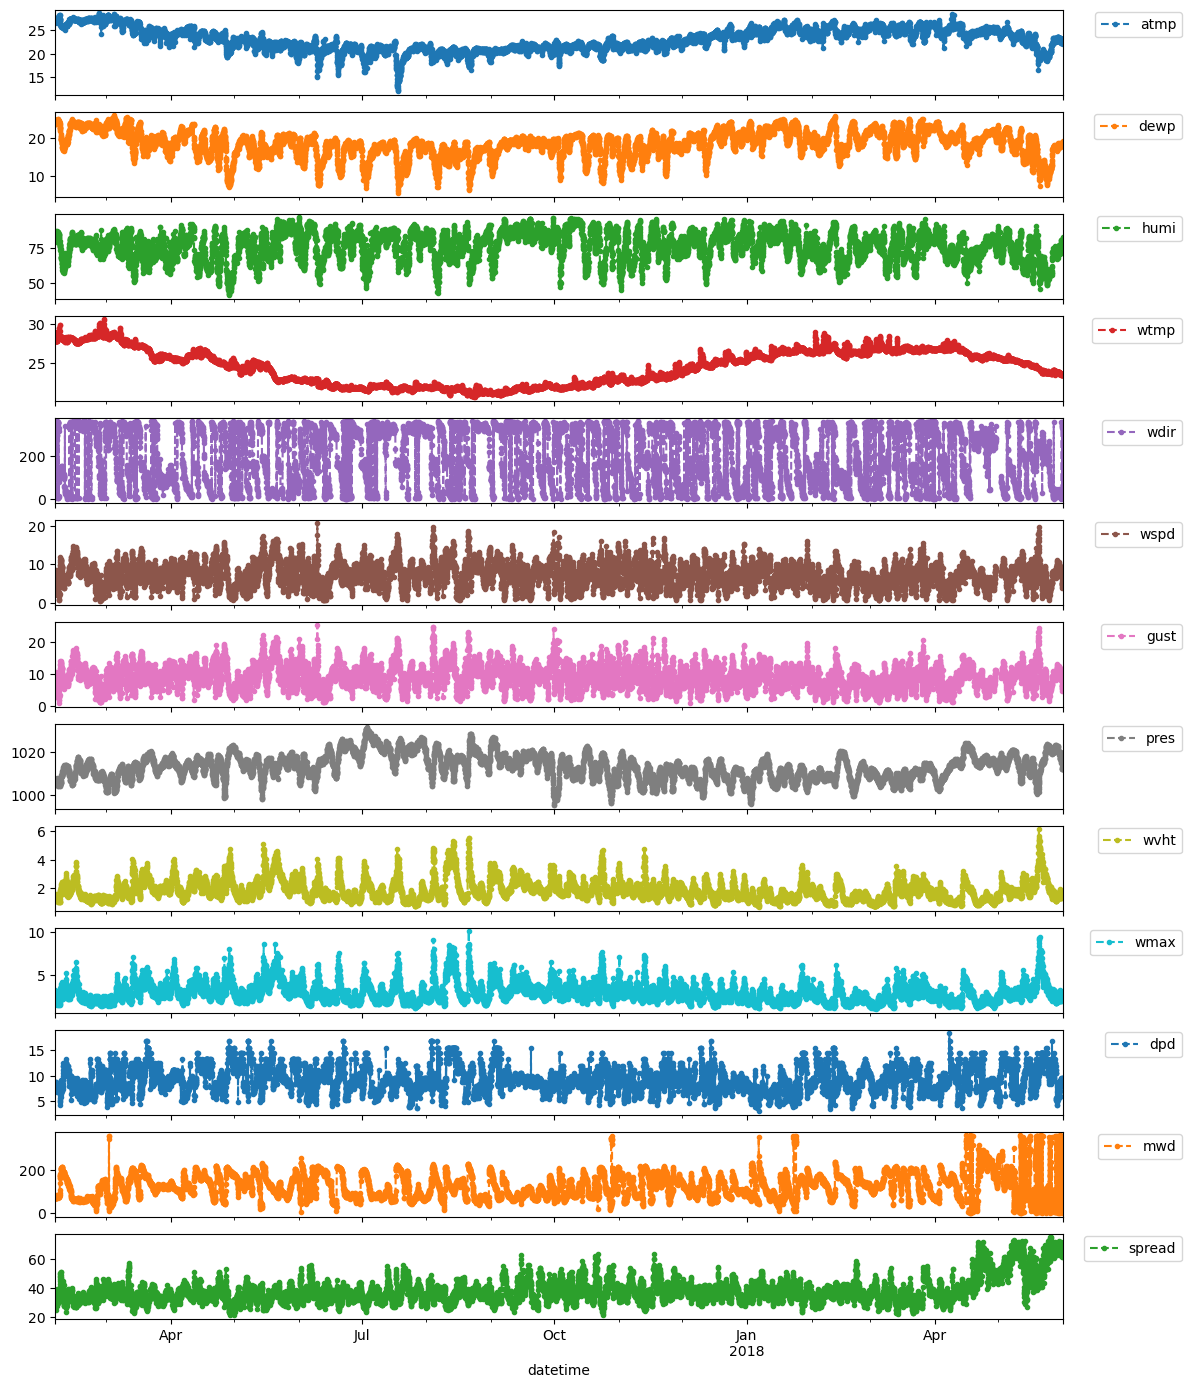

In [8]:
wave_cols = ["wvht", "wmax", "dpd", "mwd", "spread"]
meteo_cols = ["atmp", "dewp", "humi", "wtmp", "wdir", "wspd", "gust", "pres"]

df = df[meteo_cols+wave_cols]

axes = df.plot(
    subplots=True,
    layout=(13, 1),
    figsize=(13, 17),
    
    marker=".",
    linestyle="--",
)

[ax.legend(bbox_to_anchor=(1.125, 1.05)) for ax in axes.ravel()];

## Season averages

In [9]:
from oceans.ocfis import spdir2uv


u, v = spdir2uv(df["wspd"], df["wdir"], deg=True)
df["u_wind"], df["v_wind"] = u, v
df = df.drop(["wspd", "wspd"], axis=1)

In [10]:
import numpy as np


ds = xr.Dataset(df)


month_length = ds["datetime"].dt.days_in_month
weights = (
    month_length.groupby("datetime.season") / month_length.groupby("datetime.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("datetime.season").sum().values, np.ones(4))


# Calculate the weighted average
ds_weighted = (ds * weights).groupby("datetime.season").sum(dim="datetime")
ds_weighted

<xarray.Dataset>
Dimensions:  (season: 4)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables: (12/14)
    atmp     (season) float64 24.92 20.24 23.8 21.39
    dewp     (season) float64 20.68 15.9 18.93 17.56
    humi     (season) float64 77.1 75.81 73.31 79.4
    wtmp     (season) float64 26.32 21.74 25.62 22.31
    wdir     (season) float64 175.1 228.6 174.0 205.1
    gust     (season) float64 8.487 9.717 8.969 9.307
    ...       ...
    wmax     (season) float64 2.48 3.045 3.076 3.295
    dpd      (season) float64 8.492 9.207 9.882 9.236
    mwd      (season) float64 115.8 116.7 140.8 117.6
    spread   (season) float64 36.4 36.02 40.11 38.6
    u_wind   (season) float64 1.081 -1.12 0.7254 0.2007
    v_wind   (season) float64 2.947 2.301 1.791 2.518

In [11]:
cols = ["wtmp", "wvht", "u_wind", "v_wind"]

df = ds_weighted[cols].to_pandas()

df = df.rename(
    columns={
        "wtmp": "water_temperature",
        "wvht": "wave_significant_height",
    }
)

df

,water_temperature,wave_significant_height,u_wind,v_wind
season,,,,
DJF,26.322620,1.549656,1.080573,2.947172
JJA,21.743531,1.915050,-1.119849,2.300746
MAM,25.620354,1.937008,0.725439,1.790781
SON,22.310351,2.076837,0.200740,2.518411
